In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing
import numpy as np
import tarfile
import nltk
nltk.download('punkt') 

def getPath(filename):
  """
  Base Path for all documents
  """
  return "/content/drive/MyDrive/Colab Notebooks/CSE256/A1_256_sp22/" + filename

def read_unlabeled(tarfname, sentiment):
    """Reads the unlabeled data.

    The returned object contains three fields that represent the unlabeled data.

    data: documents, represented as sequence of words
    fnames: list of filenames, one for each document
    X: bag of word vector for each document, using the sentiment.vectorizer
    """
    import tarfile
    tar = tarfile.open(getPath(tarfname), "r:gz")
    class Data: pass
    unlabeled = Data()
    unlabeled.data = []
    
    unlabeledname = "unlabeled.tsv"
    for member in tar.getmembers():
        if 'unlabeled.tsv' in member.name:
            unlabeledname = member.name
            
    print(unlabeledname)
    tf = tar.extractfile(unlabeledname)
    for line in tf:
        line = line.decode("utf-8")
        text = line.strip()
        unlabeled.data.append(text)
        
            
    unlabeled.X = sentiment.count_vect.transform(unlabeled.data)
    print(unlabeled.X.shape)
    tar.close()
    return unlabeled

def read_tsv(tar, fname):
    member = tar.getmember(fname)
    print(member.name)
    tf = tar.extractfile(member)
    data = []
    labels = []
    for line in tf:
        line = line.decode("utf-8")
        (label,text) = line.strip().split("\t")
        labels.append(label)
        data.append(text)
    return data, labels

def train_classifier(X, y, C=1.0):
	"""Train a classifier using the given training data.

	Trains logistic regression on the input data with default parameters.
	"""
	cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=C)
	cls.fit(X, y)
	return cls

def evaluate(X, yt, cls, name='data'):
	"""Evaluated a classifier on the given labeled data using accuracy."""
	yp = cls.predict(X)
	acc = metrics.accuracy_score(yt, yp)
	print("  Accuracy on %s  is: %s" % (name, acc))
	return acc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def read_files(tarfname):
    """Read the training and development data from the sentiment tar file.
    The returned object contains various fields that store sentiment data, such as:

    train_data,dev_data: array of documents (array of words)
    train_fnames,dev_fnames: list of filenames of the doccuments (same length as data)
    train_labels,dev_labels: the true string label for each document (same length as data)

    The data is also preprocessed for use with scikit-learn, as:

    count_vec: CountVectorizer used to process the data (for reapplication on new data)
    trainX,devX: array of vectors representing Bags of Words, i.e. documents processed through the vectorizer
    le: LabelEncoder, i.e. a mapper from string labels to ints (stored for reapplication)
    target_labels: List of labels (same order as used in le)
    trainy,devy: array of int labels, one for each document
    """
    tar = tarfile.open(getPath(tarfname), "r:gz")
    trainname = "train.tsv"
    devname = "dev.tsv"
    for member in tar.getmembers():
        if 'train.tsv' in member.name:
            trainname = member.name
        elif 'dev.tsv' in member.name:
            devname = member.name
            
            
    class Data: pass
    sentiment = Data()
    print("-- train data")
    sentiment.train_data, sentiment.train_labels = read_tsv(tar,trainname)
    print(len(sentiment.train_data))

    print("-- dev data")
    sentiment.dev_data, sentiment.dev_labels = read_tsv(tar, devname)
    print(len(sentiment.dev_data))
    print("-- transforming data and labels")
    tar.close()

    return sentiment

def feat_control(sentiment, ngram_range):
    """
    This assign corresponded parameters to sentiment class
    """
    # sentiment.count_vect = CountVectorizer()
    sentiment.count_vect = TfidfVectorizer(ngram_range=ngram_range)
    sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
    sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)

    return sentiment


def read_data_special(tarfname, ngram_range, C_range):
  """
  This function applied corresponded n and C and get acc result
  """

  sentiment = read_files(tarfname)

  train_res, dev_res = [], []

  # Try various n and c range
  for i in range(1, ngram_range + 1):
    sentiment = feat_control(sentiment, (1, i))
    tres, dres = [], []
    for j in C_range:
      print("\nTrainTing classifier with n = {}, C = {}".format(i, j))
      cls = train_classifier(sentiment.trainX, sentiment.trainy, j)
      print("\nEvaluating")
      train_acc = evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
      dev_acc = evaluate(sentiment.devX, sentiment.devy, cls, 'dev')
      tres.append(train_acc)
      dres.append(dev_acc)
    
    train_res.append(tres)
    dev_res.append(dres)
  
  return train_res, dev_res

# Define base vars
tarfname = "data/sentiment.tar.gz"
n = 5
C_range = np.arange(1, 11, 1)
tres, dres = read_data_special(tarfname, n, C_range)

-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels

TrainTing classifier with n = 1, C = 1

Evaluating
  Accuracy on train  is: 0.9020078568310781
  Accuracy on dev  is: 0.7663755458515283

TrainTing classifier with n = 1, C = 2

Evaluating
  Accuracy on train  is: 0.9279790484504583
  Accuracy on dev  is: 0.7663755458515283

TrainTing classifier with n = 1, C = 3

Evaluating
  Accuracy on train  is: 0.9447839371453514
  Accuracy on dev  is: 0.777292576419214

TrainTing classifier with n = 1, C = 4

Evaluating
  Accuracy on train  is: 0.9559144478393714
  Accuracy on dev  is: 0.7903930131004366

TrainTing classifier with n = 1, C = 5

Evaluating
  Accuracy on train  is: 0.9624618070711479
  Accuracy on dev  is: 0.7947598253275109

TrainTing classifier with n = 1, C = 6

Evaluating
  Accuracy on train  is: 0.9681361850720209
  Accuracy on dev  is: 0.7947598253275109

TrainTing classifier with n = 1, C = 7

Evaluating
  Accuracy on tr

3.5.1


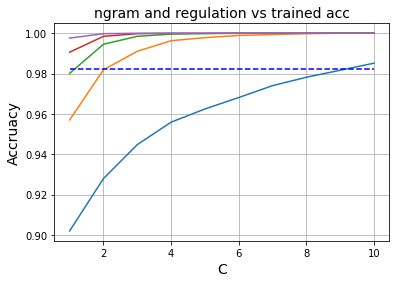

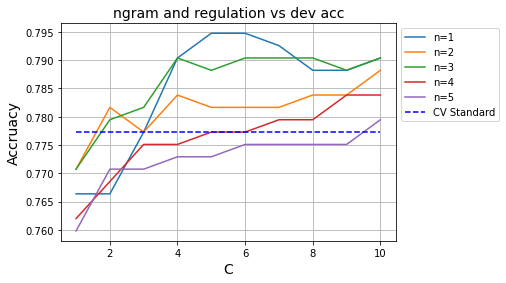

In [3]:
# ! python -m pip uninstall matplotlib albumentations -y
# ! python -m pip install https://github.com/matplotlib/matplotlib/archive/refs/tags/v3.5.1.tar.gz
# You may need to reset runtime to apply the latest version
import matplotlib
print(matplotlib.__version__)
import matplotlib.pyplot as plt

def create_fig(data):
  fig, ax = plt.subplots()
  for idx, line in enumerate(data):
    y = line
    ax.plot(C_range, y, label="n={}".format(idx + 1))

  ax.set_xlabel('C', fontsize=14)
  ax.set_ylabel('Accruacy', fontsize=14)
  ax.grid(True)

  return fig, ax

tres_fig, ax1 = create_fig(tres)
ax1.plot(C_range, [0.982103]*len(C_range), 'b--', label="CV Standard")
ax1.set_title('ngram and regulation vs trained acc', fontsize=14)
dres_fig, ax2 = create_fig(dres)
ax2.plot(C_range, [0.77729]*len(C_range), 'b--', label="CV Standard")
ax2.set_title('ngram and regulation vs dev acc', fontsize=14)


plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [4]:
import nltk
nltk.download('punkt')     

def feat_control_stop(sentiment):
    """
    This assign corresponded parameters to sentiment class
    """
    sentiment.count_vect = CountVectorizer(stop_words="english")
    sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
    sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)

    return sentiment


def feat_control_token(sentiment):
    ## Tokenizer
    from gensim.utils import tokenize
    from nltk import word_tokenize  
    from nltk.stem import SnowballStemmer
    import string

    def tokenize(text):
      tokens = nltk.word_tokenize(text)
      tokens = [i for i in tokens if i not in string.punctuation]
      stemmer = SnowballStemmer("english")
      
      stems = [stemmer.stem(i) for i in tokens]

      return tokens

    tf_vectorizer = CountVectorizer(tokenizer=tokenize)
    sentiment.count_vect = tf_vectorizer
    sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
    sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)

    return sentiment

def feat_control_combined(sentiment):
    ## Tokenizer
    from gensim.utils import tokenize
    from nltk import word_tokenize  
    from nltk.stem import SnowballStemmer
    import string

    def tokenize(text):
      tokens = nltk.word_tokenize(text)
      tokens = [i for i in tokens if i not in string.punctuation]
      stemmer = SnowballStemmer("english")
      
      stems = [stemmer.stem(i) for i in tokens]

      return tokens

    tf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2))
    sentiment.count_vect = tf_vectorizer
    sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
    sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)

    return sentiment

tarfname = "data/sentiment.tar.gz"
sentiment = read_files(tarfname)
train_d, test_d = dict(), dict()

## Baseline
train_d["baseline"] = 0.9821038847664775
test_d["baseline"] = 0.777292576419214

## Stop word
sentiment = feat_control_stop(sentiment)
print("\nTrainTing classifier with stop word")
cls = train_classifier(sentiment.trainX, sentiment.trainy)
print("\nEvaluating")
train_d["cv and stop word"] = evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
test_d["cv and stop word"] = evaluate(sentiment.devX, sentiment.devy, cls, 'dev')

## Tokenizer
sentiment = feat_control_token(sentiment)
print("\nTrainTing classifier with gensim tokenizer")
cls = train_classifier(sentiment.trainX, sentiment.trainy)
print("\nEvaluating")
train_d["cv and stem word"] = evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
test_d["cv and stem word"] = evaluate(sentiment.devX, sentiment.devy, cls, 'dev')

## Tfidf with Tokenizer
sentiment = feat_control_combined(sentiment)
print("\nTrainTing classifier with gensim tokenizer")
cls = train_classifier(sentiment.trainX, sentiment.trainy, C=5)
print("\nEvaluating")
train_d["tfidf with stem word"] = evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
test_d["tfidf with stem word"] = evaluate(sentiment.devX, sentiment.devy, cls, 'dev')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels

TrainTing classifier with stop word

Evaluating
  Accuracy on train  is: 0.9764295067656046
  Accuracy on dev  is: 0.75764192139738

TrainTing classifier with gensim tokenizer

Evaluating
  Accuracy on train  is: 0.9845045831514623
  Accuracy on dev  is: 0.7838427947598253

TrainTing classifier with gensim tokenizer

Evaluating
  Accuracy on train  is: 0.9975993016150153
  Accuracy on dev  is: 0.7882096069868996


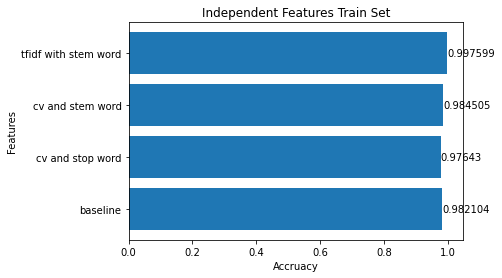

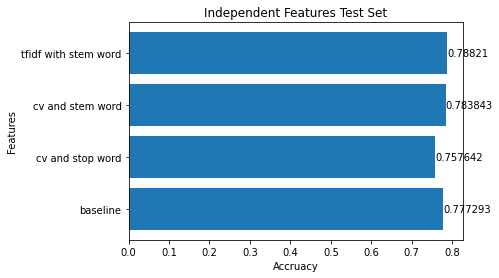

In [5]:
def create_fig2(data, title): 
  item = list(data.keys())
  values = list(data.values())
    
  fig, ax = plt.subplots()
  
  # creating the bar plot
  bars = ax.barh(item, values)
  for bars in ax.containers:
    ax.bar_label(bars)

  ax.set_ylabel("Features")
  ax.set_xlabel("Accruacy")
  ax.set_title(title)
  return fig


a = create_fig2(train_d, "Independent Features Train Set")
a = create_fig2(test_d, "Independent Features Test Set")
plt.show()